**Data Exploration**

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Utilities
import os
import re
import heapq
import pickle

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn: preprocessing, models, evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from math import sqrt


**Data Understanding**

✅ Data loaded successfully!

Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11149320 entries, 0 to 11149319
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  float64
dtypes: float64(2), int64(2)
memory usage: 340.3 MB
None
   userId  movieId  rating     timestamp
0       1        2     3.5  1.112486e+09
1       1       29     3.5  1.112485e+09
2       1       32     3.5  1.112485e+09
3       1       47     3.5  1.112485e+09
4       1       50     3.5  1.112485e+09

Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None
   movieId      

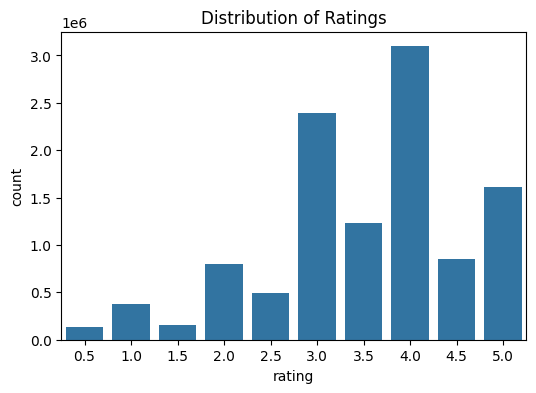

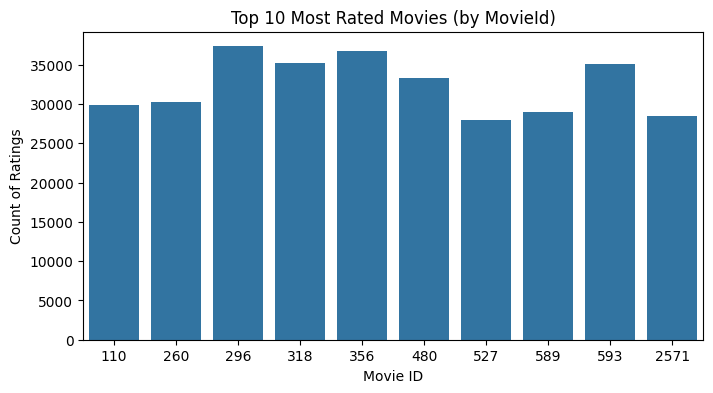

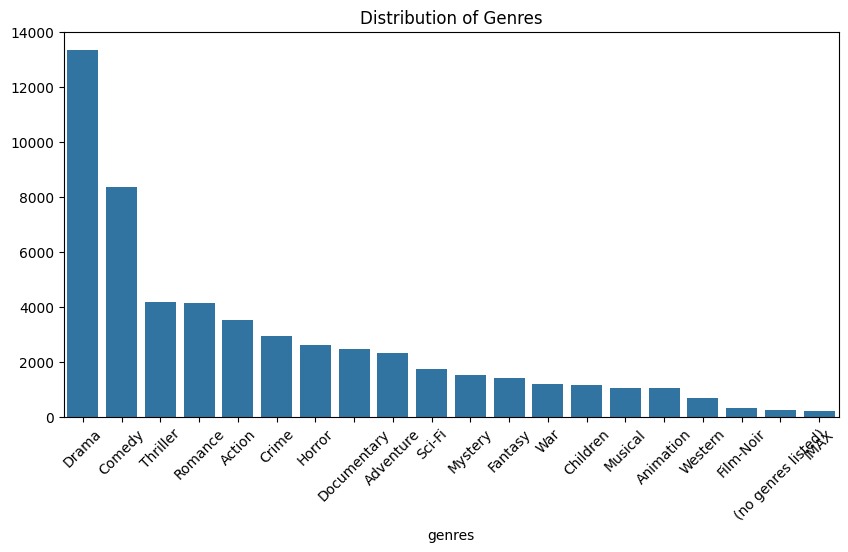

In [2]:
# --- 1. Data Collection ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
ratings = pd.read_csv("/content/ratings.csv")
movies  = pd.read_csv("/content/movies.csv")

print("✅ Data loaded successfully!")

# --- 2. Initial Overview ---
print("\nRatings Dataset Info:")
print(ratings.info())
print(ratings.head())

print("\nMovies Dataset Info:")
print(movies.info())
print(movies.head())

# --- 3. Summary Statistics ---
print("\nRatings Summary Statistics:")
print(ratings["rating"].describe())

print("\nNumber of Users:", ratings["userId"].nunique())
print("Number of Movies:", ratings["movieId"].nunique())

# --- 4. Check for Issues ---
print("\nMissing Values:")
print(ratings.isnull().sum())
print(movies.isnull().sum())

print("\nDuplicate Ratings:", ratings.duplicated().sum())
print("Duplicate Movies:", movies.duplicated().sum())

# --- 5. Visualizations ---

# Ratings distribution
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of Ratings")
plt.show()

# Top 10 most rated movies
top_movies = ratings["movieId"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.title("Top 10 Most Rated Movies (by MovieId)")
plt.xlabel("Movie ID")
plt.ylabel("Count of Ratings")
plt.show()

# Genre distribution
genre_counts = movies["genres"].str.split("|").explode().value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45)
plt.title("Distribution of Genres")
plt.show()


**Data Preprocessing Code**

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Copy datasets
ratings_clean = ratings.copy()
movies_clean  = movies.copy()

# ==============================
# 1. CLEANING
# ==============================

# Remove missing values
ratings_clean = ratings_clean.dropna(subset=["userId", "movieId", "rating"])
movies_clean  = movies_clean.dropna(subset=["movieId", "title"])

# Remove duplicates
ratings_clean = ratings_clean.drop_duplicates()
movies_clean  = movies_clean.drop_duplicates()

# Convert timestamp to datetime
ratings_clean["ts"] = pd.to_datetime(ratings_clean["timestamp"], unit="s", errors="coerce")

# Keep only the latest rating per user-movie pair
ratings_clean = ratings_clean.sort_values("ts").drop_duplicates(["userId","movieId"], keep="last")

# --- Example of binning ratings ---
# Bin ratings into categories: Low (1-2), Medium (3), High (4-5)
ratings_clean["rating_binned"] = pd.cut(
    ratings_clean["rating"],
    bins=[0,2,3,5],
    labels=["Low","Medium","High"]
)

# --- Handle missing values ---
# If user stats or movie stats are missing, fill with median
ratings_clean["rating"] = ratings_clean["rating"].fillna(ratings_clean["rating"].median())

# ==============================
# 2. REDUCTION
# ==============================

# --- Attribute Subset Selection ---
# We’ll keep only useful columns for modeling
ratings_reduced = ratings_clean[["userId","movieId","rating","ts"]]

# --- Dimensionality Reduction using PCA ---
# Example: Apply PCA on genre dummy variables
genre_dummies = movies_clean["genres"].str.get_dummies(sep="|")
pca = PCA(n_components=5)  # reduce genres into 5 components
genre_pca = pca.fit_transform(genre_dummies)

print("Explained variance by PCA:", pca.explained_variance_ratio_)

# --- Numerosity Reduction (Sampling) ---
# Sample 10% of ratings for faster prototyping
ratings_sampled = ratings_clean.sample(frac=0.1, random_state=42)

# ==============================
# 3. TRANSFORMATION
# ==============================

# --- Normalize numerical features ---
scaler = MinMaxScaler()
ratings_clean["rating_norm"] = scaler.fit_transform(ratings_clean[["rating"]])

# --- Feature Engineering: User/Movie stats ---
user_stats  = ratings_clean.groupby("userId")["rating"].agg(user_mean="mean", user_cnt="count")
movie_stats = ratings_clean.groupby("movieId")["rating"].agg(movie_mean="mean", movie_cnt="count")

ratings_clean = ratings_clean.join(user_stats, on="userId").join(movie_stats, on="movieId")

# --- Discretization: Group user activity levels ---
ratings_clean["user_activity"] = pd.qcut(ratings_clean["user_cnt"], q=3, labels=["Low","Medium","High"])

# --- Concept hierarchy generation: Convert year into decade ---
ratings_clean["year"] = ratings_clean["ts"].dt.year
ratings_clean["decade"] = (ratings_clean["year"] // 10) * 10

# ==============================
# Final Preprocessed Data
# ==============================
print("\n✅ Ratings after preprocessing:")
print(ratings_clean.head())


Explained variance by PCA: [0.19511676 0.15206917 0.10051687 0.08328727 0.0745617 ]

✅ Ratings after preprocessing:
         userId  movieId  rating    timestamp                  ts  \
4182421   28507     1176     4.0  789652004.0 1995-01-09 11:46:44   
3056639   20821       32     5.0  822873600.0 1996-01-29 00:00:00   
7754002   53434       19     1.0  822873600.0 1996-01-29 00:00:00   
6734039   46380       58     4.0  823255312.0 1996-02-02 10:01:52   
6734037   46380       52     4.0  823255313.0 1996-02-02 10:01:53   

        rating_binned  rating_norm  user_mean  user_cnt  movie_mean  \
4182421          High     0.777778   3.784483       116    3.881230   
3056639          High     1.000000   3.347368        95    3.892456   
7754002           Low     0.111111   3.296296        81    2.601248   
6734039          High     0.777778   3.729412        85    3.974735   
6734037          High     0.777778   3.729412        85    3.550292   

         movie_cnt user_activity    year  

**Data Mining & Machine Learning**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor


In [5]:
# --- Genres multi-hot encoding ---
genre_dummies = movies["genres"].str.get_dummies(sep="|")
movies_with_genres = pd.concat([movies, genre_dummies], axis=1)

In [6]:
# Merge ratings + movies + genres correctly
ratings_with_movies = (
    ratings_clean
    .merge(movies_with_genres, on="movieId", how="left")
)

In [8]:
# --- User & Movie statistics ---
user_stats = ratings_clean.groupby("userId")["rating"].agg(user_mean="mean", user_cnt="count")
movie_stats = ratings_clean.groupby("movieId")["rating"].agg(movie_mean="mean", movie_cnt="count")

In [7]:
# 🔑 Drop old duplicates if they exist
ratings_with_movies = ratings_with_movies.drop(columns=["user_mean","user_cnt"], errors="ignore")
ratings_with_movies = ratings_with_movies.drop(columns=["movie_mean","movie_cnt"], errors="ignore")

In [ ]:
# ✅ Join safely
ratings_with_movies = ratings_with_movies.join(user_stats, on="userId")
ratings_with_movies = ratings_with_movies.join(movie_stats, on="movieId")

print(ratings_with_movies.columns.tolist())

Features & Target

In [5]:

# --- Define feature groups ---
X_cols_cat = ["userId", "movieId"]  # categorical IDs
X_cols_num = ["user_mean", "movie_mean", "user_cnt", "movie_cnt"]  # statistical features
X_cols_gen = list(genre_dummies.columns)  # genre one-hot features

feature_cols = X_cols_cat + X_cols_num + X_cols_gen
target_col = "rating"

# --- Extract features & target ---
X = ratings_with_movies[feature_cols].fillna(0)
y = ratings_with_movies[target_col]


Train-Test Split

In [6]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train Models

In [ ]:
# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [ ]:
# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
# --- Gradient Boosting ---
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)